# How to crawling? - Naver Real Estate Map

In [21]:
#import custom module
import nre.classes as nc
import nre.util as nu
from IPython.display import clear_output 
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

sns.set(rc={'figure.figsize':(11.7,8.27)})

nu.IS_LOGGING = False

## 위치을 이용하여 구역 특정

In [24]:
#loc = nc.NLocation(35.18213, 128.1366) # 진주 충무공동
loc = nc.NLocation(37.49911, 127.065463) # 강남 대치동

#https://new.land.naver.com/complexes?ms=37.49911,127.065463,16&a=APT:OPST&b=B1:A1&e=RETAIL&s=EE

cur_region = nc.NRegion('', loc, '0000000000')

# 검색해서 지역 찾기
while True:
    regions = nu.get_region_list(cur_region.no)
    if len(regions) == 0: break
    for i, region in enumerate(regions): 
        print(i, region)
        
    idx = int(input("원하는 도시 인덱스(exit -1) : "))
    clear_output()
    if idx == -1: break
    cur_region = regions[idx]

서울시 강남구 개포동 1168010300 loc(37.482968 | 127.063400)


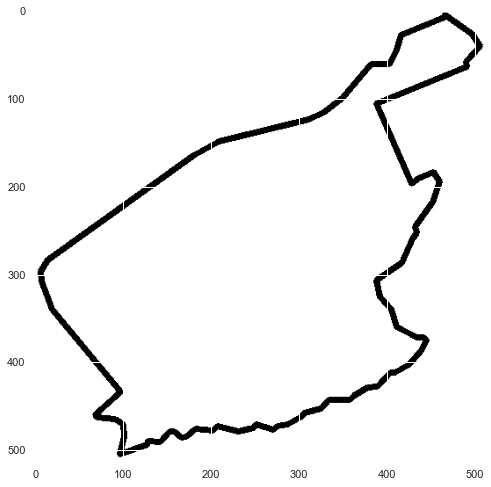

In [25]:
sector = nu.get_sector(cur_region.loc)
dm = sector.map.get_dimension()
print(sector)

plt.imshow(cv2.rotate(dm.get_bg_img(), cv2.ROTATE_90_COUNTERCLOCKWISE))

## 매물 조건 생성

In [26]:
addon = nc.NAddon(
    #direction=nc.NAddon.DIR_EACH, #전 방향 탐색의 경우 사용 - 아래 로직을 바꾸세요
    tradeType=[nc.NAddon.TRADE_DEAL, nc.NAddon.TRADE_LEASE], #목표 거래 - 매매, 전세
    estateType=[nc.NAddon.ESTATE_APT, nc.NAddon.ESTATE_OPST] #목표 매물 - 아파트, 오피스텔
)

## 조건과 구역을 이용하여 매물 탐색

In [27]:
things = [] # 매물
removed = 0
for dirr in nc.NAddon.DIR_EACH: # 모든 방향 (남향 등등)
    addon.dir = dirr # 방향 조건 선택
    things.extend(nu.get_things(sector, addon)) # 매물 저장
print('매물 수', len(things))

매물 수 53


## 구역 주변 편의 시설 탐색

In [28]:
neighbors = [] # 편의시설 기록
for nType in nc.NNeighbor.EACH: # 모든 편의시설
    values = nu.get_neighborhood(sector, nType)
    neighbors.extend(values)
    print(nType, len(values))
print('Total', len(neighbors))

BUS 64
METRO 2
INFANT 21
PRESCHOOL 4
SCHOOLPOI 5
HOSPITAL 0
PARKING 15
MART 3
CONVENIENCE 24
WASHING 20
BANK 30
OFFICE 9
Total 197


# 편의시설과 매물 간의 거리 탐색

In [29]:
# 500 == 걸어서 5~10분 이내, 버스로 1분
# 1000 == 버스로 1~2분 

standard = nu.get_distance_standard() # 거리 기준

for (key, value) in standard.items():
    print(key, value, 'm')

nu.update_things_intersection(things, neighbors, standard)

BUS 500 m
METRO 500 m
INFANT 750 m
PRESCHOOL 750 m
PRI_SCHOOL 1000 m
PUB_SCHOOL 1000 m
HOSPITAL 2000 m
PARKING 500 m
MART 500 m
CONVENIENCE 300 m
WASHING 500 m
BANK 750 m
OFFICE 1250 m


## 시각화

Dusts 250
APT	(0, 255, 0)
ABYG	(0, 255, 0)
OPST	(255, 0, 0)
OBYG	(255, 0, 0)
JGB	(0, 0, 255)
JGC	(0, 0, 255)
BUS	(0, 255, 255)
METRO	(0, 255, 255)
INFANT	(255, 255, 0)
PRESCHOOL	(255, 255, 0)
PRI_SCHOOL	(0, 0, 0)
PUB_SCHOOL	(0, 0, 0)
HOSPITAL	(0, 0, 0)
PARKING	(0, 0, 0)
MART	(0, 0, 0)
CONVENIENCE	(0, 0, 0)
WASHING	(0, 0, 0)
BANK	(0, 0, 0)
OFFICE	(0, 0, 0)


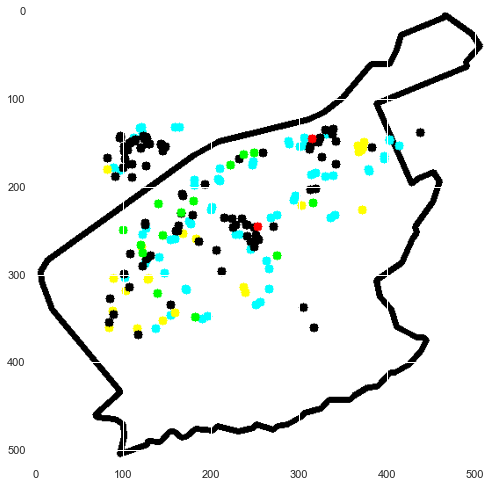

In [30]:
dm = sector.map.get_dimension()

dusts = nu.neighbors_to_dusts(neighbors, dm) # lat, lon -> 좌표 축소
dusts.extend(nu.things_to_dusts(things, dm)) # lat, lon -> 좌표 축소

color_tag = nc.NDimension.get_default_tag_color() # tag에 컬러를 연결

print('Dusts', len(dusts))
for key,value in color_tag.items():
    print(key, value, sep='\t')

plt.imshow(cv2.rotate(dm.get_img(dusts, color_tag), cv2.ROTATE_90_COUNTERCLOCKWISE)) # 출력

## Dataframe

In [31]:
import pandas as pd

def old_classifier(x): #old 구분
    return int(x[0:4])

In [32]:
total_df = pd.DataFrame(data=[t.get_list() for t in things], columns=nc.NThing.HEADER)
total_df['Old'] = total_df['Build'].apply(old_classifier)
total_df['sector'] = sector.name
total_df['city'] = sector.city

total_df

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,MART,CONVENIENCE,WASHING,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,Old,sector,city
0,개포래미안포레스트,APT,202009,EE,74.31,174.19,115.0,249,175000.0,460000.0,...,0,3,1,5,8,2,2,2020,개포동,서울시
1,더샵트리에,APT,202112,EE,132.23,135.57,135.0,249,300000.0,380000.0,...,2,2,10,24,9,2,1,2021,개포동,서울시
2,디에이치아너힐즈,APT,201908,EE,67.54,144.47,114.0,249,180000.0,530000.0,...,2,1,2,5,6,1,2,2019,개포동,서울시
3,래미안블레스티지,APT,201902,EE,67.77,169.78,113.0,249,180000.0,500000.0,...,2,2,6,2,8,1,1,2019,개포동,서울시
4,메트하임,OPST,201812,ES,44.07,60.18,44.0,794,32000.0,62000.0,...,0,4,3,4,7,0,2,2018,개포동,서울시
5,현대3차,APT,198603,ES,105.86,193.76,193.0,147,300000.0,400000.0,...,0,0,4,12,7,1,1,1986,개포동,서울시
6,개포현대(200동),APT,198607,ES,101.55,101.55,101.0,157,NaN,NaN,...,1,3,3,12,8,2,2,1986,개포동,서울시
7,개포래미안포레스트,APT,202009,ES,74.31,174.19,115.0,249,175000.0,460000.0,...,0,3,1,5,8,2,2,2020,개포동,서울시
8,우성8차,APT,198709,ES,98.87,109.35,98.0,192,243000.0,260000.0,...,0,0,3,6,7,1,1,1987,개포동,서울시
9,우성3차,APT,198412,ES,110.6,182.45,110.0,179,280000.0,400000.0,...,1,2,5,24,8,2,2,1984,개포동,서울시


In [33]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                53 non-null     object 
 1   Type                53 non-null     object 
 2   Build               53 non-null     object 
 3   Dir                 53 non-null     object 
 4   minArea             53 non-null     object 
 5   maxArea             53 non-null     object 
 6   representativeArea  53 non-null     float64
 7   floorAreaRatio      53 non-null     int64  
 8   minDeal             48 non-null     float64
 9   maxDeal             48 non-null     float64
 10  medianDeal          48 non-null     float64
 11  minLease            51 non-null     float64
 12  maxLease            51 non-null     float64
 13  medianLease         46 non-null     float64
 14  minDealUnit         48 non-null     float64
 15  maxDealUnit         48 non-null     float64
 16  medianDeal

In [34]:
total_df.describe()

,representativeArea,floorAreaRatio,minDeal,maxDeal,medianDeal,minLease,maxLease,medianLease,minDealUnit,maxDealUnit,...,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,Old
count,53.000000,53.00000,48.000000,48.000000,48.000000,51.000000,51.000000,46.000000,48.000000,48.000000,...,53.0,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,120.547170,239.90566,219041.666667,389083.333333,295416.666667,90803.921569,175215.686275,131456.521739,7207.041667,9442.875000,...,0.0,1.867925,1.018868,2.075472,4.075472,11.660377,7.735849,1.547170,1.509434,2002.433962
std,38.130629,145.42686,77153.055491,125978.017896,89951.720699,28492.117933,80440.615046,42215.166586,1616.770605,2112.422192,...,0.0,2.000363,0.820191,1.106781,2.772454,9.114535,0.812189,0.606568,0.504695,16.815183
min,44.000000,106.00000,32000.000000,55000.000000,35000.000000,28000.000000,30000.000000,30000.000000,2404.000000,3416.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,0.000000,1.000000,1984.000000
25%,101.000000,174.00000,180000.000000,380000.000000,290000.000000,80000.000000,100000.000000,95000.000000,6786.000000,8866.000000,...,0.0,0.000000,0.000000,1.000000,2.000000,5.000000,7.000000,1.000000,1.000000,1986.000000
50%,114.000000,202.00000,215500.000000,405000.000000,300000.000000,90000.000000,160000.000000,155000.000000,7346.000000,9536.000000,...,0.0,1.000000,1.000000,2.000000,3.000000,6.000000,8.000000,2.000000,2.000000,2003.000000
75%,135.000000,249.00000,280000.000000,470000.000000,342500.000000,90000.000000,240000.000000,165000.000000,8336.000000,10484.750000,...,0.0,4.000000,2.000000,3.000000,6.000000,24.000000,8.000000,2.000000,2.000000,2019.000000
max,195.000000,794.00000,390000.000000,530000.000000,400000.000000,150000.000000,280000.000000,170000.000000,8881.000000,12167.000000,...,0.0,6.000000,2.000000,4.000000,10.000000,25.000000,9.000000,2.000000,2.000000,2021.000000


## 시각화 라벨

In [17]:
target_lbl = 'minDeal'

## 방향에 따른 가격

<AxesSubplot:xlabel='Dir', ylabel='minDeal'>

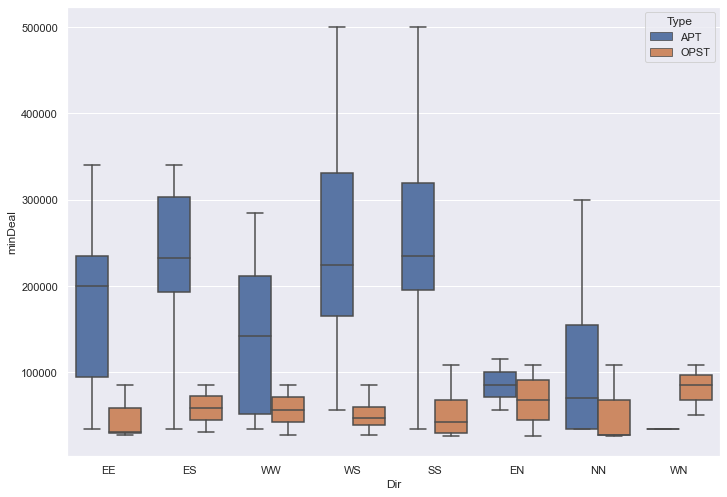

In [18]:
sns.boxplot(x='Dir', y = target_lbl, hue='Type', data=total_df)

## 오피스텔과 아파트 차이

<AxesSubplot:xlabel='Type', ylabel='minDeal'>

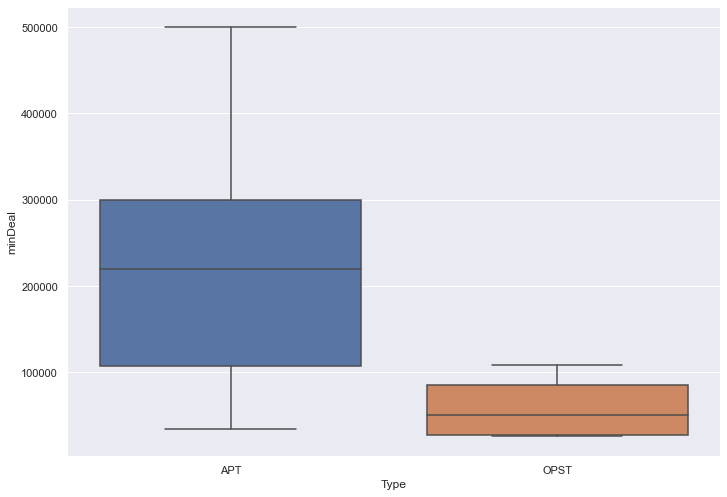

In [19]:
sns.boxplot(x='Type', y = target_lbl, data=total_df)

## 연식에 따른 차이

<AxesSubplot:xlabel='Old', ylabel='minDeal'>

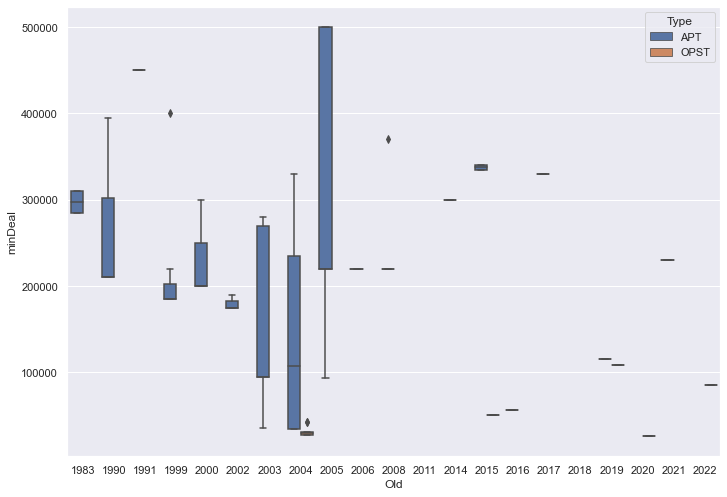

In [20]:
sns.boxplot(x='Old', y = target_lbl, hue='Type', data=total_df)

## 저장

In [18]:
total_df.to_csv('./csv/%s - %s house_price.csv' % (sector.name, sector.city), sep=',', na_rep='NaN', index=False)